In [2]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

In [3]:
cuda = True

In [4]:
batch_size = 256

In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(35),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
trainset = torchvision.datasets.FashionMNIST(
    root      = './data/', 
    train     = True,
    download  = True,
    transform = transform
)
trainloader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
    num_workers = 2
)
testset = torchvision.datasets.FashionMNIST(
    root      = './data/', 
    train     = False,
    download  = True,
    transform = transform
)
testloader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
    num_workers = 2
)
classes = (
    'top',
    'trouser',
    'pullover',
    'dress',
    'coat',
    'sandal',
    'shirt',
    'sneaker',
    'bag',
    'boot'
)

In [7]:
def show(img):
    img   = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20, 3))
    plt.imshow(np.transpose(npimg, (1,2,0)),
               interpolation='nearest')
    plt.show()

In [8]:
dataiter       = iter(trainloader)
images, labels = dataiter.next()

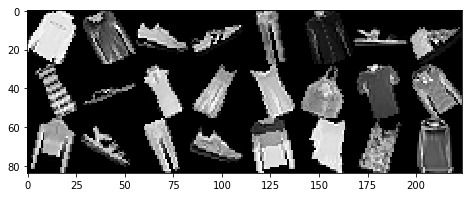

In [9]:
show(torchvision.utils.make_grid(images[:24], padding=0))

In [10]:
', '.join(classes[c] for c in labels)

'pullover, pullover, sneaker, sneaker, trouser, shirt, sandal, sneaker, dress, sandal, dress, dress, top, bag, top, pullover, pullover, sandal, trouser, sneaker, pullover, shirt, top, pullover, coat, coat, top, coat, pullover, boot, trouser, top, top, boot, dress, top, shirt, dress, sneaker, boot, sneaker, trouser, sneaker, coat, shirt, pullover, trouser, dress, sandal, sneaker, top, coat, trouser, coat, trouser, boot, bag, top, top, dress, sandal, shirt, shirt, sneaker, trouser, dress, trouser, shirt, sandal, top, bag, pullover, sneaker, shirt, dress, boot, trouser, dress, sandal, bag, sandal, boot, dress, boot, pullover, sandal, shirt, shirt, shirt, boot, trouser, dress, pullover, boot, boot, dress, dress, bag, coat, sandal, pullover, sneaker, shirt, shirt, trouser, bag, pullover, dress, dress, trouser, coat, bag, trouser, sneaker, sneaker, boot, sneaker, dress, trouser, sneaker, boot, shirt, trouser, shirt, dress, top, dress, top, top, top, shirt, sandal, sneaker, top, sandal, top, 

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1  , 64 , 3, padding = 1)
        self.conv2 = nn.Conv2d(64 , 64 , 3, padding = 1)
        self.conv3 = nn.Conv2d(64 , 64 , 3, padding = 1)
        self.conv4 = nn.Conv2d(64 , 128 , 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding = 1)
        self.fc1   = nn.Linear(128 * 7 * 7, 512)
        self.fc2   = nn.Linear(512, 512)
        self.fc3   = nn.Linear(512, 512)
        self.fc4   = nn.Linear(512, 10)
        self.bn1   = nn.BatchNorm2d(64)
        self.bn2   = nn.BatchNorm2d(64)
        self.bn3   = nn.BatchNorm2d(64)
        self.bn4   = nn.BatchNorm2d(128)
        self.bn5   = nn.BatchNorm2d(128)
        self.bn6   = nn.BatchNorm2d(128)
        self.bn7   = nn.BatchNorm1d(512)
        self.bn8   = nn.BatchNorm1d(512)
        self.bn9   = nn.BatchNorm1d(512)
        
    def forward(self, x):
        x = F.dropout(F.relu(self.bn1(self.conv1(x))), 0.7)
        x = F.dropout(F.relu(self.bn2(self.conv2(x))), 0.7)
        x = F.dropout(F.relu(self.bn3(self.conv3(x))), 0.7)
        x = F.max_pool2d(x, (2, 2))
        x = F.dropout(F.relu(self.bn4(self.conv4(x))), 0.5)
        x = F.dropout(F.relu(self.bn5(self.conv5(x))), 0.5)
        x = F.dropout(F.relu(self.bn6(self.conv6(x))), 0.5)
        x = F.max_pool2d(x, (2, 2))
        x = x.view(-1, 128 * 7 * 7)
        x = F.dropout(F.relu(self.bn7(self.fc1(x))), 0.3)
        x = F.dropout(F.relu(self.bn8(self.fc2(x))), 0.3)
        x = F.dropout(F.relu(self.bn9(self.fc3(x))), 0.3)
        x = self.fc4(x)
        
        return x

In [12]:
cnn       = CNN().cuda() if cuda else CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters())
epoch     = 40
print_int = 100

In [ ]:
def validate_model(train = True):
    cnn.eval()
    total_loss            = 0.0
    total_prediction      = 0
    total_good_prediction = 0
    batch_number          = 0
    for X, y in trainloader if train else testloader:
        X, y = Variable(X), Variable(y)
        X, y = (X.cuda(), y.cuda()) if cuda else (X, y)

        y_pred                 = cnn(X)
        total_loss            += criterion(y_pred, y).data[0]
        total_prediction      += y_pred.size()[0]
        total_good_prediction += (y_pred.max(dim = 1)[1].data.cpu() == y.data.cpu()).sum()
        batch_number          += 1
    
    return total_loss / batch_number, 100 * total_good_prediction / total_prediction 

In [ ]:
for i in range(epoch):
    running_loss = 0
    for j, (X_train, y_train) in enumerate(trainloader):
        cnn.train()
        X_train, y_train = Variable(X_train), Variable(y_train)
        X_train, y_train = (X_train.cuda(), y_train.cuda()) if cuda else (X_train, y_train)
        
        optimizer.zero_grad()
        y_pred = cnn(X_train)
        loss   = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        if j % print_int == 0:
            train_loss, train_acc = validate_model(True)
            val_loss, val_acc     = validate_model(False)
            print(
                "running_loss:", running_loss.item()  / (print_int if j != 0 else 1),
                "train_loss:", train_loss.item(),
                "valid_loss:", val_loss.item(), "valid_acc:", val_acc.item()
            )
            running_loss = 0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


running_loss: 2.3096609115600586 train_loss: 2.3027710914611816 valid_loss: 2.3027379512786865 valid_acc: 10
running_loss: 0.6036235809326171 train_loss: 0.45867541432380676 valid_loss: 0.4806478023529053 valid_acc: 81
running_loss: 0.41543949127197266 train_loss: 0.3720729649066925 valid_loss: 0.40128812193870544 valid_acc: 85
running_loss: 0.34497180581092834 train_loss: 0.3654119074344635 valid_loss: 0.40196844935417175 valid_acc: 85
running_loss: 0.34459724426269533 train_loss: 0.36590418219566345 valid_loss: 0.41220685839653015 valid_acc: 85
running_loss: 0.3207188415527344 train_loss: 0.3225734829902649 valid_loss: 0.3546592891216278 valid_acc: 87
running_loss: 0.28065937757492065 train_loss: 0.33713236451148987 valid_loss: 0.36395105719566345 valid_acc: 86
